In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

import os
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

# 그래프 시각화
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 2015 ~ 2020년도 데이터 가져오기
- 드라이브 마운트 필요

In [ ]:
# Google drive mount or 폴더 클릭 후 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filenames=['/content/drive/MyDrive/teamproject/data/baseball_' + str(x) + '.csv' for x in list(range(2015,2021))]
filenames

['/content/drive/MyDrive/teamproject/data/baseball_2015.csv',
 '/content/drive/MyDrive/teamproject/data/baseball_2016.csv',
 '/content/drive/MyDrive/teamproject/data/baseball_2017.csv',
 '/content/drive/MyDrive/teamproject/data/baseball_2018.csv',
 '/content/drive/MyDrive/teamproject/data/baseball_2019.csv',
 '/content/drive/MyDrive/teamproject/data/baseball_2020.csv']

In [ ]:
data = pd.DataFrame()
for filename in tqdm(filenames):
    temp = pd.read_csv(filename)
    data = pd.concat([data,temp])

100%|██████████| 6/6 [00:01<00:00,  4.18it/s]


In [ ]:
baseball_data = data.copy() # data copy는 왜 만든 거죠??
# 원본 데이터를 훼손하지 않고 만들기 위해??

In [ ]:
baseball_data.head()

,G_ID,GDAY_DS,T_ID,VS_T_ID,HEADER_NO,TB_SC,PA,AB,RBI,RUN,...,HP,KK,GD,LOB,P_HRA_RT,P_AB_CN,P_HIT_CN,OBP,OOO,win
0,20150328HHNE0,20150328,HH,NE,0,T,54.0,42.0,4.0,4.0,...,1.0,7.0,0.0,24.0,0.133333,15,2,0.352941,0.238095,0.0
1,20150328HHNE0,20150328,NE,HH,0,B,46.0,40.0,5.0,5.0,...,0.0,7.0,1.0,18.0,0.090909,11,1,0.304348,0.200000,1.0
2,20150328KTLT0,20150328,KT,LT,0,T,46.0,35.0,8.0,9.0,...,1.0,8.0,1.0,23.0,0.285714,14,4,0.511111,0.400000,0.0
3,20150328KTLT0,20150328,LT,KT,0,B,42.0,37.0,12.0,12.0,...,1.0,8.0,1.0,17.0,0.437500,16,7,0.439024,0.378378,1.0
4,20150328LGHT0,20150328,LG,HT,0,T,34.0,29.0,1.0,1.0,...,0.0,6.0,2.0,17.0,0.200000,10,2,0.333333,0.241379,0.0


In [ ]:
# baseball_data.columns

### 데이터의 결측치와 데이터 형태 확인

In [ ]:
# baseball_data.info()

In [ ]:
#baseball_data.describe()

### 날짜 데이터, HEADER_NO 삭제
- HEADER_NO 데이터의 경우 0 값만 존재하므로 삭제

In [ ]:
baseball_data = baseball_data.drop(['G_ID','GDAY_DS','HEADER_NO'], axis=1)
baseball_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8656 entries, 0 to 1367
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   T_ID      8656 non-null   object 
 1   VS_T_ID   8656 non-null   object 
 2   TB_SC     8656 non-null   object 
 3   PA        8656 non-null   float64
 4   AB        8656 non-null   float64
 5   RBI       8656 non-null   float64
 6   RUN       8656 non-null   float64
 7   HIT       8656 non-null   float64
 8   H2        8656 non-null   int64  
 9   H3        8656 non-null   int64  
 10  HR        8656 non-null   float64
 11  SB        8656 non-null   int64  
 12  CS        8656 non-null   int64  
 13  SF        8656 non-null   int64  
 14  BB        8656 non-null   float64
 15  HP        8656 non-null   float64
 16  KK        8656 non-null   float64
 17  GD        8656 non-null   float64
 18  LOB       8656 non-null   float64
 19  P_HRA_RT  8656 non-null   float64
 20  P_AB_CN   8656 non-null   int6

###무승부 제거

In [ ]:
print(baseball_data['win'].value_counts())
baseball_data = baseball_data[baseball_data['win']!=0.5]
print(baseball_data['win'].value_counts())

0.0    4261
1.0    4261
0.5     134
Name: win, dtype: int64
0.0    4261
1.0    4261
Name: win, dtype: int64


### 상관관계 정도를 그래프로 그리기

In [ ]:
# baseball_data_corr['win'].sort_values(ascending=False)

In [ ]:
# baseball_data_corr['win'].sort_values(ascending=False).plot.barh()

=> corr로 상관성 분석 시, RUN, RBI, OBP, OOO, P_HIT_CN, HIT feature들이 win과 40% 이상 상관성을 가지고 있음

### 팀명 라벨 인코딩

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(baseball_data['T_ID']) # 각 카테고리별로 라벨을 만들어주고 
baseball_data.loc[:,'T_ID'] = le.transform(baseball_data['T_ID']) # 생성한 라벨로 문자열 형태의 T_ID를 대체
# loc는 특정 행이나 열을 조회하는 기능을 하는데, 먼저 열에 대해 fit을 사용하고 transform을 사용해 구조를 변형시켜준다...?
baseball_data.loc[:,'VS_T_ID'] = le.transform(baseball_data['VS_T_ID'])
baseball_data.head()

,T_ID,VS_T_ID,TB_SC,PA,AB,RBI,RUN,HIT,H2,H3,...,HP,KK,GD,LOB,P_HRA_RT,P_AB_CN,P_HIT_CN,OBP,OOO,win
0,0,6,T,54.0,42.0,4.0,4.0,10.0,4,0,...,1.0,7.0,0.0,24.0,0.133333,15,2,0.352941,0.238095,0.0
1,6,0,B,46.0,40.0,5.0,5.0,8.0,4,0,...,0.0,7.0,1.0,18.0,0.090909,11,1,0.304348,0.200000,1.0
2,2,4,T,46.0,35.0,8.0,9.0,14.0,2,0,...,1.0,8.0,1.0,23.0,0.285714,14,4,0.511111,0.400000,0.0
3,4,2,B,42.0,37.0,12.0,12.0,14.0,10,0,...,1.0,8.0,1.0,17.0,0.437500,16,7,0.439024,0.378378,1.0
4,3,1,T,34.0,29.0,1.0,1.0,7.0,4,2,...,0.0,6.0,2.0,17.0,0.200000,10,2,0.333333,0.241379,0.0


- train_x, train_y : 훈련 데이터
- test_x, test_y : 테스트 데이터

In [ ]:
train_data = baseball_data[['RUN','RBI','OBP','OOO','P_HIT_CN','HIT','T_ID','VS_T_ID']]
train_target = baseball_data['win']

In [ ]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(train_data, train_target, test_size = 0.2, random_state = 42) # 학습데이터와 평가데이터의 비율을 8:2 로 분할| 
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) # 데이터 개수 확인

(6817, 8) (1705, 8) (6817,) (1705,)


## GBM(Gradient Boosting Machine) 적용

In [ ]:
# GBM 수행 시간 측정
start_time = time.time()

# 모델 설정
gb_clf = GradientBoostingClassifier(random_state = 0)
gb_clf.fit(train_x, train_y)

# GBM 학습 및 예측 성능 평가
gb_pred = gb_clf.predict(test_x)
gb_accuracy = accuracy_score(test_y, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.1f} 초'.format(time.time() - start_time))

GBM 정확도: 0.7900
GBM 수행 시간: 0.6 초


### **6) Feature importance 시각화**

<br>

변수(feature)들이 모델의 분류 예측에 각각 얼마만큼의 영향을 끼쳤는지를 확인해보고자 합니다. 

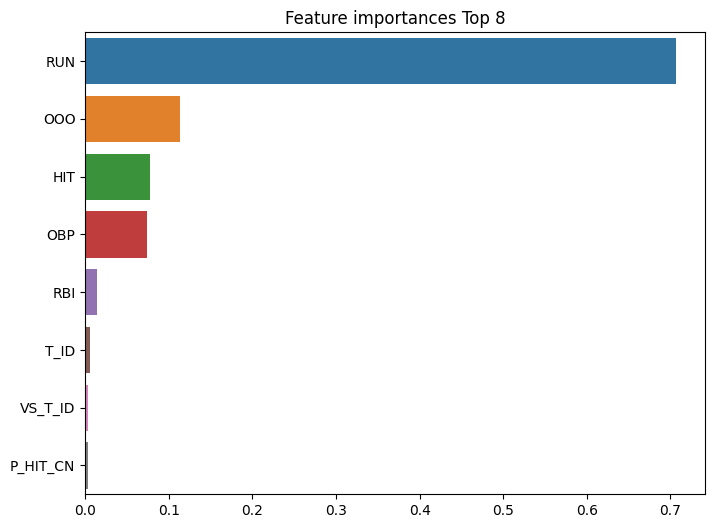

In [ ]:
# feature_importances_ 속성을 이용해 변수 중요도 시각화하기
ftr_importances_values = gb_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=train_x.columns)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 8')
sns.barplot(x = ftr_top15, y = ftr_top15.index)
plt.show()

### **7) 모델 최적화 - GridSearchCV를 이용한 하이퍼 파라미터 튜닝**

기본 하이퍼 파라미터만으로도 95%가 넘는 매우 높은 분류 예측 정확도를 보이는데요. 

일반적으로 GBM이 랜덤 포레스트보다 높은 예측 성능을 보인다고 합니다.

그러나 데이터셋 사이즈가 커질수록 랜덤 포레스트에 비해 수행 시간이 오래 걸리고, 하이퍼 파라미터 튜닝 노력도 더 필요합니다. 

<br>

GridSearchCV는 머신러닝 모델의 성능 향상을 위해 쓰이는 기법중 하나입니다. 

사용자가 모델의 하이퍼 파라미터의 값을 리스트로 입력하면 값에 대한 경우의 수마다 예측 성능을 측정 평가하여 비교하면서 최적의 하이퍼 파라미터 값을 찾는 과정을 진행합니다.

GridSearchCV를 이용해 모델의 성능을 높이기 위한 최적의 파라미터를 찾고자 합니다.

In [ ]:
# GridSearchCV 수행 시간 측정
start_time = time.time()

params = {
    'n_estimators': [100, 300, 500], 
    'max_depth': [6, 10],
    'min_samples_leaf': [6, 8, 12],
    'min_samples_split': [8, 16],
    'learning_rate': [0.05, 0.1]
}

grid_cv = GridSearchCV(gb_clf, param_grid = params, cv = 2)
grid_cv.fit(train_x, train_y)

print('최적의 파라미터 :',grid_cv.best_params_)
print('최고의 예측 정확도 :{0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 수행 시간: {0:.1f} 초'.format(time.time() - start_time))

최적의 파라미터 : {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고의 예측 정확도 :0.7979
GridSearchCV 수행 시간: 416.4 초


###랜덤서치를 통한 하이퍼파라미터 최적화

In [ ]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

# RandomizedSearchCV 수행 시간 측정
start_time = time.time()

params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(1, 20),
    'min_samples_leaf': randint(2, 20),
    'min_samples_split': randint(2, 20),
    'learning_rate': uniform(0.001, 0.2)
}

random_cv = RandomizedSearchCV(gb_clf, params, n_iter=100, n_jobs=-1, cv = 2)
random_cv.fit(train_x, train_y)

print('최적의 파라미터 :',random_cv.best_params_)
print('최고의 예측 정확도 :{0:.4f}'.format(random_cv.best_score_))
print('GridSearchCV 수행 시간: {0:.1f} 초'.format(time.time() - start_time))

최적의 파라미터 : {'learning_rate': 0.1394907961313124, 'max_depth': 2, 'min_samples_leaf': 14, 'min_samples_split': 12, 'n_estimators': 348}
최고의 예측 정확도 :0.8021
GridSearchCV 수행 시간: 504.1 초


위에서 실행한 GridSearchCV를 바탕으로 파라미터를 조정한 새로운 모델(gb_clf2)을 만들고 앞서 만든 모델과 비교해보겠습니다.

In [ ]:
# GBM 수행 시간 측정
start_time = time.time()

# 하이퍼 파라미터 조정한 모델 gb_clf2
gb_clf2 = GradientBoostingClassifier(learning_rate = 0.1,    # 기존 모델 0.1
                                     max_depth = 6,           # 기존 모델 3 
                                     min_samples_leaf = 8,    # 기존 모델 1
                                     min_samples_split = 8,   # 기존 모델 2
                                     n_estimators = 100)      # 기존 모델 100
gb_clf2.fit(train_x, train_y)

# 모델 학습 및 예측 성능 평가
gb_pred2 = gb_clf2.predict(test_x)
gb_accuracy2 = accuracy_score(test_y, gb_pred2)

print('하이퍼 파라미터 조정하기 전 GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('하이퍼 파라미터 조정한 후 GBM 정확도: {0:.4f}'.format(gb_accuracy2))
print('하이퍼 파라미터 조정한 GBM 수행 시간: {0:.1f} 초'.format(time.time() - start_time))

하이퍼 파라미터 조정하기 전 GBM 정확도: 0.7900
하이퍼 파라미터 조정한 후 GBM 정확도: 0.7953
하이퍼 파라미터 조정한 GBM 수행 시간: 1.6 초


위에서 실행한 RandomSearchCV를 바탕으로 파라미터를 조정한 새로운 모델(gb_clf3)을 만들고 앞서 만든 모델과 비교해보겠습니다.

In [ ]:
# GBM 수행 시간 측정
start_time = time.time()

# 하이퍼 파라미터 조정한 모델 gb_clf3
gb_clf3 = GradientBoostingClassifier(learning_rate = 0.1394907961313124,    # 기존 모델 0.1
                                     max_depth = 2,           # 기존 모델 6 
                                     min_samples_leaf = 14,    # 기존 모델 8
                                     min_samples_split = 12,   # 기존 모델 8
                                     n_estimators = 348)      # 기존 모델 100
gb_clf3.fit(train_x, train_y)

# 모델 학습 및 예측 성능 평가
gb_pred3 = gb_clf3.predict(test_x)
gb_accuracy3 = accuracy_score(test_y, gb_pred3)

print('하이퍼 파라미터 조정하기 전 GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('하이퍼 파라미터 GridSearch로 조정한 후 GBM 정확도: {0:.4f}'.format(gb_accuracy2))
print('하이퍼 파라미터 RandomSearch로 조정한 후 GBM 정확도: {0:.4f}'.format(gb_accuracy3))
print('하이퍼 파라미터 조정한 GBM 수행 시간: {0:.1f} 초'.format(time.time() - start_time))

하이퍼 파라미터 조정하기 전 GBM 정확도: 0.7900
하이퍼 파라미터 GridSearch로 조정한 후 GBM 정확도: 0.7953
하이퍼 파라미터 RandomSearch로 조정한 후 GBM 정확도: 0.7959
하이퍼 파라미터 조정한 GBM 수행 시간: 1.6 초
